## Раздел III. Контроль и очистка данных

### Целью этапа является 
- проверка непротиворечивости данных
- преобразование форматов
- устранение избыточности
- контроль целостности
- анализ и обработка "выбросов"

__Результатом__ этапа должен быть подготовленный для построения моделей набор данных

In [10]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from datetime import datetime

In [11]:
# загрузим рабочий набор из предыдущего этапа 
orders = pd.read_csv('orders_3.csv', low_memory=False, dtype={'CUST_ZIP_C': object})

In [12]:
# импортируем из вспомогателього модуля 'my_utils' класс для работы с orders
from my_utils import Order

# создадим объект
obj_orders = Order(orders)

### а) удаление неинформативных показателей

In [13]:
orders.columns

Index([u'SA_HDR_TIC', u'CUST_NAM', u'SA_HDR_DAT', u'SA_HDR_AMT', u'CUST_CAT',
       u'CUST_PROFI', u'CUST_PRO01', u'CUST_PRO02', u'CUST_PRO03',
       u'CUST_PRO04', u'CUST_PRO05', u'LINES_QTY', u'ITEMS_QTY', u'CUST_ZIP_C',
       u'CUST_CITY', u'CUST_LST_P', u'CUST_LST01', u'CUST_BAL',
       u'CUST_RET_QTY', u'CUST_RET_SUM', u'CUST_TIME_DEAL', u'CUST_TOTAL_AMT',
       u'SA_HDR_DOW', u'CUST_DIST'],
      dtype='object')

In [14]:
# удалим колонки SA_HDR_TIC - номер накладной, SA_HDR_DAT - дату накладной,
# CUST_LST_P и CUST_LST01 - показатели последней продажи
# CUST_ZIP_C - не нужен, т.к. на его основе вычислено расстояние
# CUST_BAL - текущий балланс, нельзя использовать, т.к. содержит историческую составляющую

orders.drop(['SA_HDR_TIC','SA_HDR_DAT','CUST_LST_P','CUST_LST01', 'CUST_BAL'], axis=1, inplace=True)

### б) устранение пустых значений в показателях

In [15]:
# выведем значение CUST_CAT
orders.CUST_CAT.unique()

array(['PH', 'RG', '1', 'PA', 'PL', 'AOPH', nan, 'RAYPH', '001', 'MHPH',
       'AR', 'MH', 'AO', 'ARPA', 'NJ', 'ABW', 'RAJPA', '14.50', 'ANG',
       'ARPH', '19.20', 'NSL', 'RAYPA', 'GP', 'MHPA', 'RAJPH', 'GB', 'HB',
       'BH', 'RAY', 'L', '500', 'RRJ', '2'], dtype=object)

In [16]:
# пустые значения в этом поле заменим на категорию 'NO-CAT'
orders.CUST_CAT.fillna('NO-CAT', inplace=True)

In [17]:
# покупатели с неправильными zip-кодами (для них не найдено расстояние)
bad_zip_codes = orders[pd.isnull(orders.CUST_DIST)].CUST_ZIP_C.unique()
print(bad_zip_codes)

['19101' '19369' '19346' '27702' '17128' '27102' '08903' '50771' '08646'
 '08076' '87719' '88620']


In [18]:
# заполним отсутствующие расстояния медианой расстояний по датасету
median_dist = orders['CUST_DIST'].median()
print 'медиана = {}'.format(median_dist)

orders.CUST_DIST.fillna(median_dist, inplace=True)

медиана = 32.0


In [19]:
# удалим zip-коды за ненадобностью, т.к. на их основе вычислены расстояния
#orders.drop(['CUST_ZIP_C'], axis=1, inplace=True)

In [20]:
# преобразуем день недели в категорийный признак
orders.SA_HDR_DOW = pd.Categorical(orders['SA_HDR_DOW'])

/Users/sergey/anaconda/lib/python2.7/site-packages/matplotlib/axes/_base.py:3193: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=178615, top=178615
  'bottom=%s, top=%s') % (bottom, top))


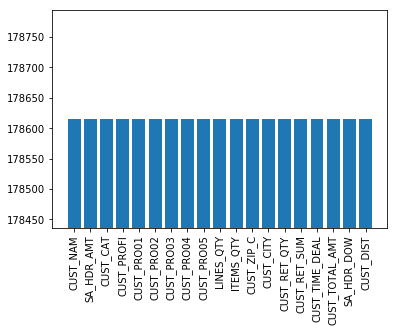

In [21]:
obj_orders.futures_dist()

### в) удаление отрицательных значений SA_HDR_AMT (возвратов), т.к. мы прогнозируем продажи

In [22]:
orders = orders[orders.SA_HDR_AMT > 0]
print orders.shape

(170234, 19)


In [23]:
orders = orders.drop_duplicates()

In [26]:
# сохранить очищеный набор в orders_3-1.csv
orders.to_csv('orders_3-1.csv', index=False)

## исследуем статистики отдельных показателей

### a) количественные показатели

#### 1. _ПРОДАЖИ_ - SA_HDR_AMT

In [73]:
print 'всего отрицательных значений: {}'.format(orders[orders.SA_HDR_AMT < 0].shape[0])

всего отрицательных значений: 7971


In [74]:
# удалим из датафрейма возвраты, т.к. нас интересуют только продажи
orders = orders[orders.SA_HDR_AMT > 0]

count    170234.000000
mean       1733.446236
std        3826.586135
min           0.390000
25%         421.320000
50%        1017.455000
75%        2146.130000
max      183483.000000
Name: SA_HDR_AMT, dtype: float64

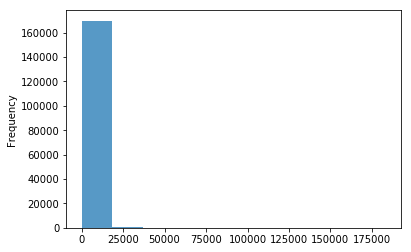

In [75]:
# выведем график частотности и описательную статистику показателя
orders['SA_HDR_AMT'].plot.hist(alpha=.75)
orders.SA_HDR_AMT.describe()

#### _из таблицы и графика видно, что 3 квартиля показывают сопоставимые объемы продаж, а в 4-м есть выбросы. Стандартное отклонение >> среднего, что указывает на значительную дисперсию. Исследуем эти выбросы._

In [76]:
# посмотрим на покупателей с объемами покупок > 25000
big_sales = orders[orders.SA_HDR_AMT > 25000].CUST_NAM.unique()

print list(big_sales)

['PNK WHOLESALE', 'K+T WHOLESALE DISTRIBUTOR', 'BUTTS & BETTS, LLC', 'ANG WHOLESALE CASH &CARRY', 'SUNOCO STATE RD', 'SUNOCO STREET ROAD', '7-ELEVEN MORRISVILLE', 'SUN WHOLESALE', '7-11 BRACE ROAD']


In [77]:
# из их названия видно, что это очевидно оптовые покупатели и для их анализа нужно строить 
# отдельную от розничных покупателей модель
# удалим из рассмотрения накладные, у которых значение SA_HDR_AMT > среднего + ст.отклонение

mean, std = orders.SA_HDR_AMT.mean(), orders.SA_HDR_AMT.std()

orders = orders[orders.SA_HDR_AMT < mean + std]

count    163226.000000
mean       1334.277119
std        1209.880352
min           0.390000
25%         399.360000
50%         952.795000
75%        1953.135000
max        5559.690000
Name: SA_HDR_AMT, dtype: float64


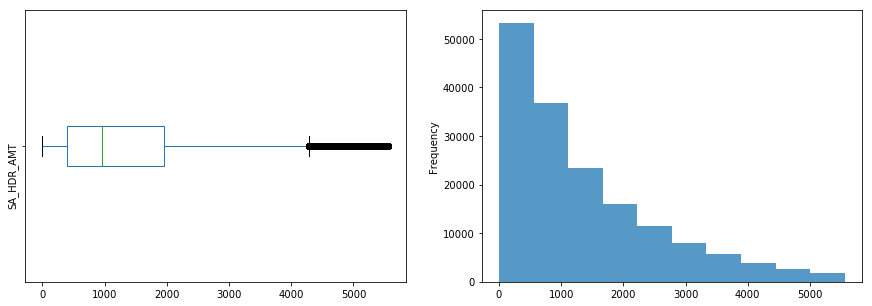

In [78]:
print orders.SA_HDR_AMT.describe()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
orders['SA_HDR_AMT'].plot.box(vert=False, ax=axes[0], subplots=True, rot=90)
#axes[0].set_title('A')
orders['SA_HDR_AMT'].plot.hist(ax=axes[1], subplots=True, alpha=.75)
#axes[1].set_title('B')
fig.show()

#### из графиков видно, что незначительные выбросы остались, но частотность распределения стала показывать приемлемый вид

In [79]:
orders.shape

(163226, 19)

####  2. _ДИСКАУНТЫ (скидки)_   - CUST_PROFI, CUST_PRO01 ... 

In [80]:
# показатели CUST_PROFI, CUST_PRO01 ... - одной природы: дискаунты покупателя
discounts = ['CUST_PROFI','CUST_PRO01', 'CUST_PRO02', 'CUST_PRO03', 'CUST_PRO04', 'CUST_PRO05']

In [81]:
orders[discounts].head()

,CUST_PROFI,CUST_PRO01,CUST_PRO02,CUST_PRO03,CUST_PRO04,CUST_PRO05
0,3.00,2.10,1.80,0.0,0.0,0.0
1,2.00,1.50,1.50,0.0,0.0,0.0
2,2.00,1.25,1.10,0.0,0.0,0.0
3,3.65,3.00,2.65,0.0,0.0,0.0
4,2.00,1.25,1.10,0.0,0.0,0.0


In [82]:
orders[discounts].describe()

,CUST_PROFI,CUST_PRO01,CUST_PRO02,CUST_PRO03,CUST_PRO04,CUST_PRO05
count,163226.000000,163226.000000,163226.000000,163226.000000,163226.000000,163226.000000
mean,2.609703,2.191034,2.048478,0.024166,0.050781,0.022608
std,1.357107,1.203728,1.173728,0.183930,0.189056,0.177485
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1.500000,1.250000,0.000000,0.000000,0.000000
50%,3.000000,2.500000,2.400000,0.000000,0.000000,0.000000
75%,3.500000,3.000000,2.750000,0.000000,0.000000,0.000000
max,4.250000,4.000000,4.000000,2.000000,1.500000,3.000000


In [83]:
# рассчитаем матрицу попарных корреляций
orders[discounts].corr()

,CUST_PROFI,CUST_PRO01,CUST_PRO02,CUST_PRO03,CUST_PRO04,CUST_PRO05
CUST_PROFI,1.000000,0.983879,0.965174,0.064351,0.115839,0.050184
CUST_PRO01,0.983879,1.000000,0.984089,0.069499,0.107623,0.059302
CUST_PRO02,0.965174,0.984089,1.000000,0.058234,0.089822,0.049175
CUST_PRO03,0.064351,0.069499,0.058234,1.000000,0.864049,0.816315
CUST_PRO04,0.115839,0.107623,0.089822,0.864049,1.000000,0.776247
CUST_PRO05,0.050184,0.059302,0.049175,0.816315,0.776247,1.000000


In [84]:
from pandas.plotting import scatter_matrix

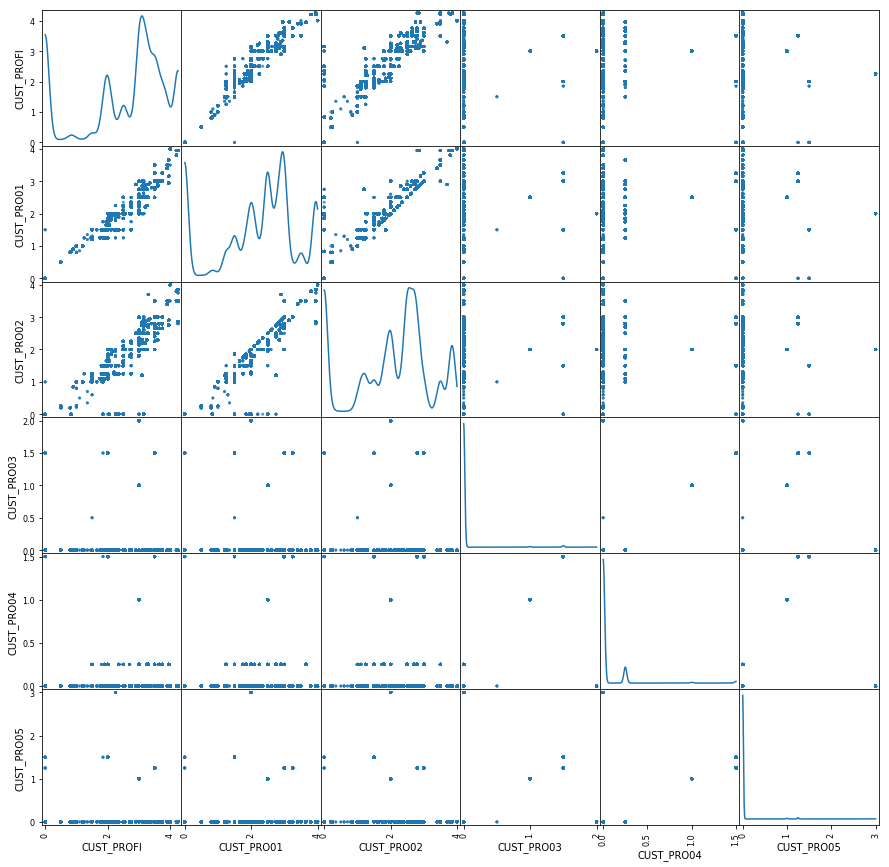

In [85]:
# построим графики попарного распределения значений скидок
scatter_matrix(orders[discounts], diagonal='kde', figsize=(15,15), alpha=.75);

#### корреляционная матрица и графики пказывают, что
- скидки __CUST_PROFI - CUST_PRO02__ имею ярко выраженную линейную зависимость и могут быть "свернуты" в один показатель (CUST_DISC)
- распределение скидок __CUST_PROF03 - CUST_PRO05__ обладают большим смещением и оценка их зависимости неочевидна, т.о. их можно в дальнейшем не рассматривать

In [86]:
# свернем значения показателей CUST_PROFI - CUST_PRO02 по среднему
orders['CUST_DISC'] = (orders.CUST_PROFI + orders.CUST_PRO01 + orders.CUST_PRO02) / 3

In [87]:
orders.CUST_DISC.describe()

count    163226.000000
mean          2.283072
std           1.235511
min           0.000000
25%           1.666667
50%           2.666667
75%           3.083333
max           4.016667
Name: CUST_DISC, dtype: float64

In [88]:
# уберем из датафрейма дискаунты
orders.drop(discounts, axis=1, inplace=True)

In [89]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 163226 entries, 0 to 178599
Data columns (total 14 columns):
CUST_NAM          163226 non-null object
SA_HDR_AMT        163226 non-null float64
CUST_CAT          163226 non-null object
LINES_QTY         163226 non-null int64
ITEMS_QTY         163226 non-null float64
CUST_ZIP_C        163226 non-null object
CUST_CITY         163226 non-null object
CUST_RET_QTY      163226 non-null float64
CUST_RET_SUM      163226 non-null float64
CUST_TIME_DEAL    163226 non-null int64
CUST_TOTAL_AMT    163226 non-null float64
SA_HDR_DOW        163226 non-null category
CUST_DIST         163226 non-null float64
CUST_DISC         163226 non-null float64
dtypes: category(1), float64(7), int64(2), object(4)
memory usage: 17.6+ MB


In [90]:
# анализ показателей возвратов
orders[['CUST_RET_QTY', 'CUST_RET_SUM']].describe()

,CUST_RET_QTY,CUST_RET_SUM
count,163226.000000,163226.000000
mean,240.927028,-26050.107242
std,494.485489,48156.494438
min,0.000000,-141745.360000
25%,8.000000,-16627.240000
50%,27.000000,-5335.320000
75%,76.000000,-1384.070000
max,1433.000000,0.000000


In [91]:
# преобразуем поле CUST_RET_SUM в его абсолютное значение
orders.CUST_RET_SUM = abs(orders.loc[:,'CUST_RET_SUM'])

In [93]:
# сохраним датафрейм для следующего этапа
orders.to_csv('orders_4.csv')